In [1]:
import numpy as np
import yaml
import os
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 

from utils.load_datasets import load_dataset
from models import vgg
from models.cvae import CVAE
from models.vgg_vmmix import BiternionVGGMixture

Using TensorFlow backend.


In [2]:
print("""Please enter a dataset for evaluation\n
       0 - CAVIAR-o
       1 - TownCentre
       2 - IDIAP""")

dataset_id = int(input())

if dataset_id == 0:
    pdf_scaler = 2.0
    theta_zero_location = 'E'
    dataset_name = "CAVIAR-o"
    dataset_path = 'data/CAVIAR-o.pkl.gz'
    pretrained_path = 'pretrained_models/CAVIAR-o'
    net_output = 'pan'
    return_info = True
elif dataset_id == 1:
    theta_zero_location = "S"
    dataset_name = "TownCentre"
    dataset_path = 'data/TownCentre.pkl.gz'
    net_output = 'pan'
    pdf_scaler = 7.0
    return_info = False
    return_info = True
elif dataset_id == 2:
    theta_zero_location = 'S'
    pdf_scaler = 2.0
    dataset_name = "IDIAP"
    dataset_path = 'data//IDIAP.pkl'
    print("""Please enter desired net output
           0 - pan
           1 - tilt
           2 - roll""")
    net_output_id = int(input())
    if net_output_id == 0:
        net_output = 'pan'
    elif net_output_id == 1:
        net_output = 'tilt'
    elif net_output_id == 2:
        net_output = 'roll'
    return_info = False
    
print("Working with %s dataset, net output: %s" % (dataset_name, net_output))

Please enter a dataset for evaluation

       0 - CAVIAR-o
       1 - TownCentre
       2 - IDIAP
2
Please enter desired net output
           0 - pan
           1 - tilt
           2 - roll
0
Working with IDIAP dataset, net output: pan


In [3]:
if return_info:
    (xtr, ytr_bit, ytr_deg, info_tr), (xval, yval_bit, yval_deg, info_val), (xte, yte_bit, yte_deg, info_te) = load_dataset(dataset_name,
                                                                                            dataset_path,
                                                                                            net_output,
                                                                                            return_info=return_info)
else:
    (xtr, ytr_bit, ytr_deg), (xval, yval_bit, yval_deg), (xte, yte_bit, yte_deg) = load_dataset(dataset_name,
                                                                                            dataset_path,
                                                                                            net_output,
                                                                                            return_info=return_info)

image_height, image_width, n_channels = xtr.shape[1], xtr.shape[2], xtr.shape[3]

image samples from IDIAP


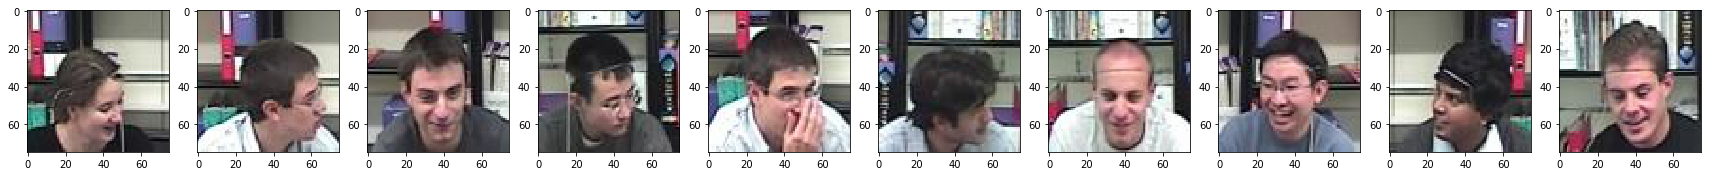

In [4]:
print("image samples from %s" % dataset_name)

n_samples = 10
frame_ids = np.random.randint(0, xtr.shape[0], n_samples)

fig, axis = plt.subplots(1, n_samples, figsize=[30, 10])

def bgr_to_rgb(img):
    return np.stack([img[:,:,2], img[:,:,1], img[:,:,0]], axis=2)

for i, fid in enumerate(frame_ids):
    if dataset_name == 'TownCentre':
        img = bgr_to_rgb(xtr[fid])
    else:
        img = xtr[fid]
    axis[i].imshow(img)

plt.show()

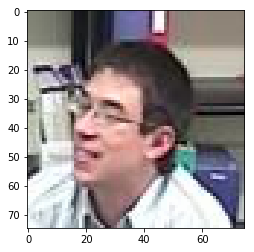

In [470]:
plt.imshow(xte[10])

In [6]:
def bgr_to_rgb(img):
    return np.stack([img[:,:,2], img[:,:,1], img[:,:,0]], axis=2)

In [5]:
if dataset_name == 'IDIAP':
    pretrained_path = os.path.join('pretrained_models', dataset_name, net_output)
else:    
    pretrained_path = os.path.join('pretrained_models', dataset_name)

vggbit_cosine_config_path = os.path.join(pretrained_path, 'cosine/model.best.params.yml')
vggbit_cosine_weights_path = os.path.join(pretrained_path, 'cosine/model.best.weights.hdf5')
vggbit_likelihood_config_path = os.path.join(pretrained_path, 'likelihood/model.best.params.yml')
vggbit_likelihood_weights_path =  os.path.join(pretrained_path, 'likelihood/model.best.weights.hdf5')
vmmix_config_path =  os.path.join(pretrained_path, 'vm_mixture/model.best.params.yml')
vmmix_weights_path =  os.path.join(pretrained_path, 'vm_mixture/model.best.weights.hdf5')
cvae_config_path =  os.path.join(pretrained_path, 'cvae/model.best.params.yml')
cvae_weights_path =  os.path.join(pretrained_path, 'cvae/model.best.weights.hdf5')

In [7]:
def load_config(net_config_path):
    with open(net_config_path, 'r') as f:
        net_config = yaml.load(f)
    return net_config

vggbit_cosine_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=False,
                                loss_type='cosine',
                                **load_config(vggbit_cosine_config_path))
vggbit_cosine_model.load_weights(vggbit_cosine_weights_path)
vggbit_cosine_model.finetune_kappa(xval, yval_bit, max_kappa=1000)

vggbit_likelihood_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=True,
                                loss_type='vm_likelihood',
                                **load_config(vggbit_likelihood_config_path))
vggbit_likelihood_model.load_weights(vggbit_likelihood_weights_path)

vmmix_model = BiternionVGGMixture(image_height=image_height,
                            image_width=image_width,
                            n_channels=3,
                            **load_config(vmmix_config_path))

vmmix_model.load_weights(vmmix_weights_path)

cvae_model = CVAE(image_height=image_height,
                 image_width=image_width,
                 n_channels=n_channels,
                 **load_config(cvae_config_path))

cvae_model.load_weights(cvae_weights_path)

using cosine loss..
using likelihood loss..


In [8]:
def eval_all_models(x, y_deg, data_part, eval_cvae=True, n_samples=50):
    
    results = {}
    
    print("*****EVALUATING ON %s*****"%data_part)
    print("evaluating VGGBit (cosine loss)..")
    results['cosine'] = vggbit_cosine_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating VGGBit (likelihood loss)..")
    results['likelihood'] = vggbit_likelihood_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating VM-Mixture..")
    results['mixture'] = vmmix_model.evaluate(x, y_deg, data_part, return_per_image=True)
    if eval_cvae: 
        print("evaluating CVAE..")
        results['cvae'] = cvae_model.evaluate(x, y_deg, data_part, return_per_image=True, n_samples=n_samples)
    
    return results

In [ ]:
#results_train = eval_all_models(xtr, ytr_deg, 'train', eval_cvae=False)
#results_val = eval_all_models(xval, yval_deg, 'validation', eval_cvae=False)
#results_test = eval_all_models(xte, yte_deg, 'test', eval_cvae=False)

In [10]:
n_random_frames = 2
if dataset_name == 'CAVIAR-o':
    frames = [4793, 2399, 1614, 3149, 2579, 2326]
elif dataset_name == 'TownCentre':
    frames = [850, 350, 318, 364]
elif dataset_name == 'IDIAP':
    frames = [3295, 10729, 11081]

random_frames =  np.random.randint(0, len(xte), n_random_frames) #np.arange(starting_frame, starting_frame+n_frames)
frames.extend(random_frames)
n_samples = 50
xvals =  np.arange(0, 2*np.pi, 0.01)

n_frames =  len(frames)

results = eval_all_models(xte[frames], yte_deg[frames], 'mini_test', eval_cvae=True, n_samples=n_samples)

pdfs_dict = {}

vggcosine_acc_pdf = vggbit_cosine_model.pdf(xte[frames], xvals)

vgglikelihood_acc_pdf = vggbit_likelihood_model.pdf(xte[frames], xvals)

vmmix_pdfs, vmmix_acc_pdf, component_probs = vmmix_model.pdf(xte[frames], xvals)

cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(xte[frames], xvals, n_samples=n_samples)

*****EVALUATING ON mini_test*****
evaluating VGGBit (cosine loss)..
MAAD error (mini_test) : 7.320888 pm 4.291919SEM
log-likelihood (mini_test) : 0.160530 pm 0.682755SEM
evaluating VGGBit (likelihood loss)..
MAAD error (mini_test) : 6.502808 pm 1.958591SEM
log-likelihood (mini_test) : 0.573637 pm 0.266420SEM
evaluating VM-Mixture..
MAAD error (mini_test) : 1.562719 pm 0.559223SEM
log-likelihood (mini_test) : 1.003246 pm 0.276247SEM
evaluating CVAE..
MAAD error (mini_test) : 5.931954 pm 1.965303SEM
ELBO (mini_test) : 0.599585 pm 0.173981SEM
Approx Log-Likelihood, importance sampling (mini_test) : 0.656621 pm 0.173580SEM
KL-div (mini_test) : 0.035188 pm0.006459SEM


In [11]:
from scipy.misc import imresize


def make_halo(img, standard_size=[75,75]):
    img_halo = np.copy(img)
    lx, ly = img.shape[0:2]
    X, Y = np.ogrid[0:lx, 0:ly]
    mask = (X - lx / 2) ** 2 + (Y - ly / 2) ** 2 > lx * ly / 4
    img_halo[mask] = 1
    img_halo = imresize(img_halo, size=standard_size)
    return img_halo

def frame_image(img, frame_width):
    b = frame_width # border size in pixel
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    framed_img = np.ones((b+ny+b, b+nx+b, img.shape[2]), dtype='uint8')*255
    for i in range(0,3):
        framed_img[b:-b, b:-b,i] = img[:,:,i]
    return framed_img

def plot_pdf_circle(ax_pdf, ax_img, img, xvals, pdf, ypred_rad=None, ytrue_rad=None, title='', show_legend=True,
                   theta_zero_location='E', show_ticks=True, pdf_scaler=1.0, pdf_color='green', pred_color='darkgreen'):
    
    
    #fig = plt.figure(figsize=(7, 7))
    #rect = [0.1, 0.1, 0.8, 0.8]

    #ax_img  = fig.add_axes(rect, frameon=False)
    ax_img.axis("off")
    img_halo = frame_image(make_halo(img), 30)
    ax_img.imshow(img_halo)

    ax_pdf.set_yticks([])
    ax_pdf.set_xticks(([ytrue_rad]))
    #ax_pdf.set_xticks(([ypred_rad]))
    if show_ticks:
        ax_pdf.set_xticklabels(["%d°"%np.rad2deg(ytrue_rad)], fontsize=13) 
    else:
        ax_pdf.set_xticklabels([])
    ax_pdf.set_xlim(0, 1.0)
    ax_pdf.set_ylim(0, 17)
    ax_pdf.patch.set_alpha(0.1)
    ax_pdf.set_theta_zero_location(theta_zero_location)
    margin = 9.2 #9.2
    border = 0.8 #0.8
    
    if 'Baseline' not in title:
        ax_pdf.fill_between(xvals, np.ones(xvals.shape[0])*margin, np.ones(xvals.shape[0])*(margin+border), color='white')
        ax_pdf.fill_between(xvals, np.ones(xvals.shape[0])*(margin+border), pdf*pdf_scaler+margin+border, color=pdf_color, alpha=0.5, label='$p_{\\theta}(\phi | \mathbf{x})$')
    #ax_pdf.fill_between(xvals, np.ones(xvals.shape[0])*(margin+border), pdf*pdf_scaler+margin+border, color=pdf_color, alpha=0.5, label='predicted von Mises density')
    ax_pdf.set_title(title, fontsize=20)
    if ytrue_rad is not None:
        ax_pdf.axvline(ytrue_rad, ymin=0.54, color='red', linewidth=3, label='$\phi_{true}$') #label='$\phi_{true}$'
    if ypred_rad is not None:
        #ax_pdf.axvline(ypred_rad, ymin=0.54, color=pred_color, linewidth=4, label='BiternionVGG prediction')
        ax_pdf.axvline(ypred_rad, ymin=0.54, ls='dashed', color=pred_color, linewidth=3, label='$\phi_{pred}(\mathbf{x}, \\theta)$')
    if show_legend:
        ax_pdf.legend(fontsize=13, loc=3, framealpha=1.0)

    return fig

In [10]:
from utils.angles import bit2deg
from matplotlib import rc

# # activate latex text rendering
# rc('text', usetex=False)


yte_rad = np.deg2rad(bit2deg(yte_bit))

fid = np.random.randint(0, n_frames)

savepath = os.path.join('images/', dataset_name)

if not os.path.exists(savepath):
    os.makedirs(savepath, exist_ok=True)

for fid in range(4, n_frames):
    fig = plt.figure(figsize=(20, 7))
    for mid, method in enumerate(['cosine', 'likelihood', 'mixture', 'cvae']):

        global_frame_id = frames[fid]
        if dataset_name=="TownCentre":
            img = bgr_to_rgb(xte[global_frame_id])
        else: 
            img = xte[global_frame_id]
        
        if method=='cvae':
            log_likelihood = results[method]['importance_log_likelihood'][fid] 
            show_legend=True
        else:
            log_likelihood = results[method]['log_likelihood'][fid]  
            show_legend=True

        maad = results[method]['maad'][fid]
        
        if method=='cosine':
            method_title = 'Baseline'
            title = "$\mathbf{Baseline}$ \n\n $\log{\mathcal{L}}$=%.2f\n $\Delta_{AAD}$=%.2f°" % (log_likelihood, maad)
            pdf = vggcosine_acc_pdf[fid]
            pdf_color = 'blue'
            pred_color = 'darkblue'
        elif method=='likelihood':
            method_title = 'Single von Mises'
            title = "$\mathbf{Single}$ $\mathbf{von}$ $\mathbf{Mises}$\n\n $\log{\mathcal{L}}$=%.2f\n $\Delta_{AAD}$=%.2f°" % (log_likelihood, maad)
            pdf = vgglikelihood_acc_pdf[fid]
            pdf_color = 'green'
            pred_color = 'darkgreen'
        elif method=='mixture':
            method_title = 'Finite mixture'
            title = "$\mathbf{Finite}$ $\mathbf{mixture}$ \n\n $\log{\mathcal{L}}$=%.2f\n $\Delta_{AAD}$=%.2f°" % (log_likelihood, maad)
            pdf = vmmix_acc_pdf[fid]
            pdf_color = 'purple'
            pred_color = 'purple'
        elif method=='cvae':
            method_title = 'CVAE'
            title = "$\mathbf{CVAE}$ \n\n $\log{\mathcal{L}}$=%.2f\n $\Delta_{AAD}$=%.2f°" % (log_likelihood, maad)
            pdf = cvae_acc_pdfs[fid]
            pdf_color = 'orange'
            pred_color = 'orange'

        
        #title = "%s \n \n $\log{\mathcal{L}}$=%.2f\n $\Delta_{AAD}$=%.2f°" % (method_title, log_likelihood, maad)
        #title = "$ \log{\mathcal{L}}$=%.2f\n $\Delta_{AAD}$=%.2f°" % (log_likelihood, maad)
        ypred_rad = np.deg2rad(results[method]['point_preds'][fid])
        ytrue_rad = yte_rad[global_frame_id]
        #title='Frame %d (%s)'%(global_frame_id, method)

        axs_img = fig.add_subplot(1, 4, mid+1, frameon=False)
        axs_pdf = fig.add_subplot(1, 4, mid+1, projection='polar')

        fig = plot_pdf_circle(axs_pdf, axs_img, img, xvals, 
                        pdf=pdf, 
                        ypred_rad=ypred_rad,
                        ytrue_rad=ytrue_rad,
                        title=title,
                        theta_zero_location=theta_zero_location,
                        pdf_scaler=7.0,
                        show_ticks=False,
                        pdf_color=pdf_color,
                        pred_color=pred_color,
                        show_legend=False)
        
        #fig.suptitle("%s, test frame %d" % (dataset_name, global_frame_id), fontsize=30)
        img_path = os.path.join(savepath, str(global_frame_id) + '.png')
        fig.savefig(img_path, dpi=300)

NameError: name 'n_frames' is not defined

### Ablation experiment

In [12]:
n_random_frames = 5

frames =  np.random.randint(0, len(xte), n_random_frames) #np.arange(starting_frame, starting_frame+n_frames)

In [12]:
def show_images(x):
    
    n_images = len(x)
    
    fig, axis = plt.subplots(1, n_images, figsize=[30, 10])

    def bgr_to_rgb(img):
        return np.stack([img[:,:,2], img[:,:,1], img[:,:,0]], axis=2)

    for fid in range(0, n_images):
        if dataset_name == 'TownCentre':
            img = bgr_to_rgb(x[fid])
        else:
            img = x[fid]
        axis[fid].imshow(img)
    
    return

In [117]:
cv2.blur?

In [13]:
import cv2

def get_blurred_images(img, blur_ksizes):
    
    blurred_set = np.tile(img, [len(blur_ksizes), 1, 1, 1])
    
    for i, kval in enumerate(blur_ksizes):
        blurred_set[i] = cv2.blur(img, ksize=(kval,kval))
    
    return blurred_set


def get_blurred_dataset(data, blur_ksize):
    
    blurred_set = np.zeros(data.shape)
    
    for fid in range(0, len(data)):
        blurred_set[fid] = cv2.blur(data[fid], ksize=(blur_ksize, blur_ksize))
    
    return blurred_set

In [15]:
blur_3 = get_blurred_dataset(xte, 3)

In [14]:
def blur_evaluation(x, ytrue_deg, blur_ksizes=np.arange(1, 101, 2.0, dtype='int8')):
    
    results = []
    
    for ksize in blur_ksizes:
        
        print("\n\n KERNEL SIZE =%d" %ksize)
        x_blurred = get_blurred_dataset(x, ksize)
        blur_results = eval_all_models(x_blurred, ytrue_deg, 'blurred_image, k=%d'%ksize, eval_cvae=True, n_samples=10)
        results.append(blur_results)
        
    return results

In [23]:
prior_mean = np.mean(yval_deg)
prior_std = np.std(yval_deg)

In [24]:
prior_std

26.37336

In [21]:
np.mean(ytr_deg)

0.0

In [ ]:
np.tile()

In [18]:
blur_ksizes = np.arange(1, 11, 2.0, dtype='int8')
blur_results = blur_evaluation(xte[0:10], yte_deg[0:10], blur_ksizes)



 KERNEL SIZE =1
*****EVALUATING ON blurred_image, k=1*****
evaluating VGGBit (cosine loss)..
MAAD error (blurred_image, k=1) : 4.559649 pm 1.157519SEM
log-likelihood (blurred_image, k=1) : 0.725775 pm 0.079177SEM
evaluating VGGBit (likelihood loss)..
MAAD error (blurred_image, k=1) : 5.085994 pm 1.209010SEM
log-likelihood (blurred_image, k=1) : 0.633057 pm 0.161797SEM
evaluating VM-Mixture..
MAAD error (blurred_image, k=1) : 4.762829 pm 1.295730SEM
log-likelihood (blurred_image, k=1) : 0.813885 pm 0.169158SEM
evaluating CVAE..
MAAD error (blurred_image, k=1) : 6.232383 pm 1.378909SEM
ELBO (blurred_image, k=1) : 0.572136 pm 0.167575SEM
Approx Log-Likelihood, importance sampling (blurred_image, k=1) : 0.593841 pm 0.178645SEM
KL-div (blurred_image, k=1) : 0.050257 pm0.005668SEM


 KERNEL SIZE =3
*****EVALUATING ON blurred_image, k=3*****
evaluating VGGBit (cosine loss)..
MAAD error (blurred_image, k=3) : 6.458439 pm 2.407742SEM
log-likelihood (blurred_image, k=3) : 0.360606 pm 0.385971S

In [137]:
blur_results[0]['cvae'].keys()

dict_keys(['elbo', 'elbo_sem', 'kl_div', 'kl_div_sem', 'maad_loss', 'maad_loss_sem', 'importance_log_likelihood', 'importance_log_likelihood_sem', 'point_preds', 'maad'])

In [16]:
def get_curve(blur_results, method_name):
    
    curves = {}
    if method_name=='cvae':
        curves['log_likelihood'] = [np.mean(blur_results[kid][method_name]['importance_log_likelihood']) for kid in range(0, len(blur_ksizes))]
        curves['log_likelihood_sem']  = [blur_results[kid][method_name]['importance_log_likelihood_sem'] for kid in range(0, len(blur_ksizes))]
    else:
        curves['log_likelihood'] = [blur_results[kid][method_name]['log_likelihood_mean'] for kid in range(0, len(blur_ksizes))]
        curves['log_likelihood_sem']  = [blur_results[kid][method_name]['log_likelihood_sem'] for kid in range(0, len(blur_ksizes))]
    
    if method_name=='mixture':
        curves['maad']  = [blur_results[kid][method_name]['maad_loss'] for kid in range(0, len(blur_ksizes))]
        curves['maad_sem']  = [blur_results[kid][method_name]['maad_sem'] for kid in range(0, len(blur_ksizes))]
    else:
        curves['maad']  = [blur_results[kid][method_name]['maad_loss'] for kid in range(0, len(blur_ksizes))]
        curves['maad_sem']  = [blur_results[kid][method_name]['maad_loss_sem'] for kid in range(0, len(blur_ksizes))]
    
    return curves

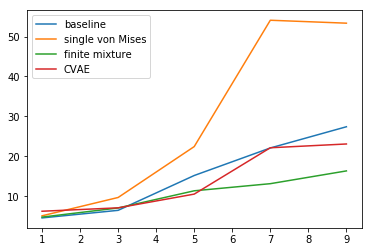

In [25]:
cosine_curves = get_curve(blur_results, 'cosine')
likelihood_curves = get_curve(blur_results, 'likelihood')
mixture_curves = get_curve(blur_results, 'mixture')
cvae_curves = get_curve(blur_results, 'cvae')

plt.plot(blur_ksizes, cosine_curves['maad'], label='baseline')
plt.plot(blur_ksizes, likelihood_curves['maad'], label='single von Mises')
plt.plot(blur_ksizes, mixture_curves['maad'], label='finite mixture')
plt.plot(blur_ksizes, cvae_curves['maad'], label='CVAE')

plt.legend()

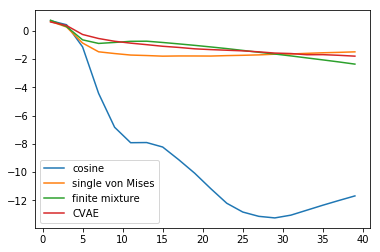

In [156]:
plt.plot(blur_ksizes, cosine_curves['log_likelihood'], label='baseline')
plt.plot(blur_ksizes, likelihood_curves['log_likelihood'], label='single von Mises')
plt.plot(blur_ksizes, mixture_curves['log_likelihood'], label='finite mixture')
plt.plot(blur_ksizes, cvae_curves['log_likelihood'], label='CVAE')

plt.legend()

In [50]:
cosine_curves['maad_sem']

[1.1575192581250342,
 2.40774172497609,
 5.705902423872711,
 9.561299900304887,
 9.217668317452247]

In [53]:
np.asarray(cosine_curves['maad'])-np.asarray(cosine_curves['maad_sem'])

array([  3.40213021,   4.05069715,   9.47957769,  12.51893653,  18.17677138])

/Users/sergey/BiternionNet/py_env/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


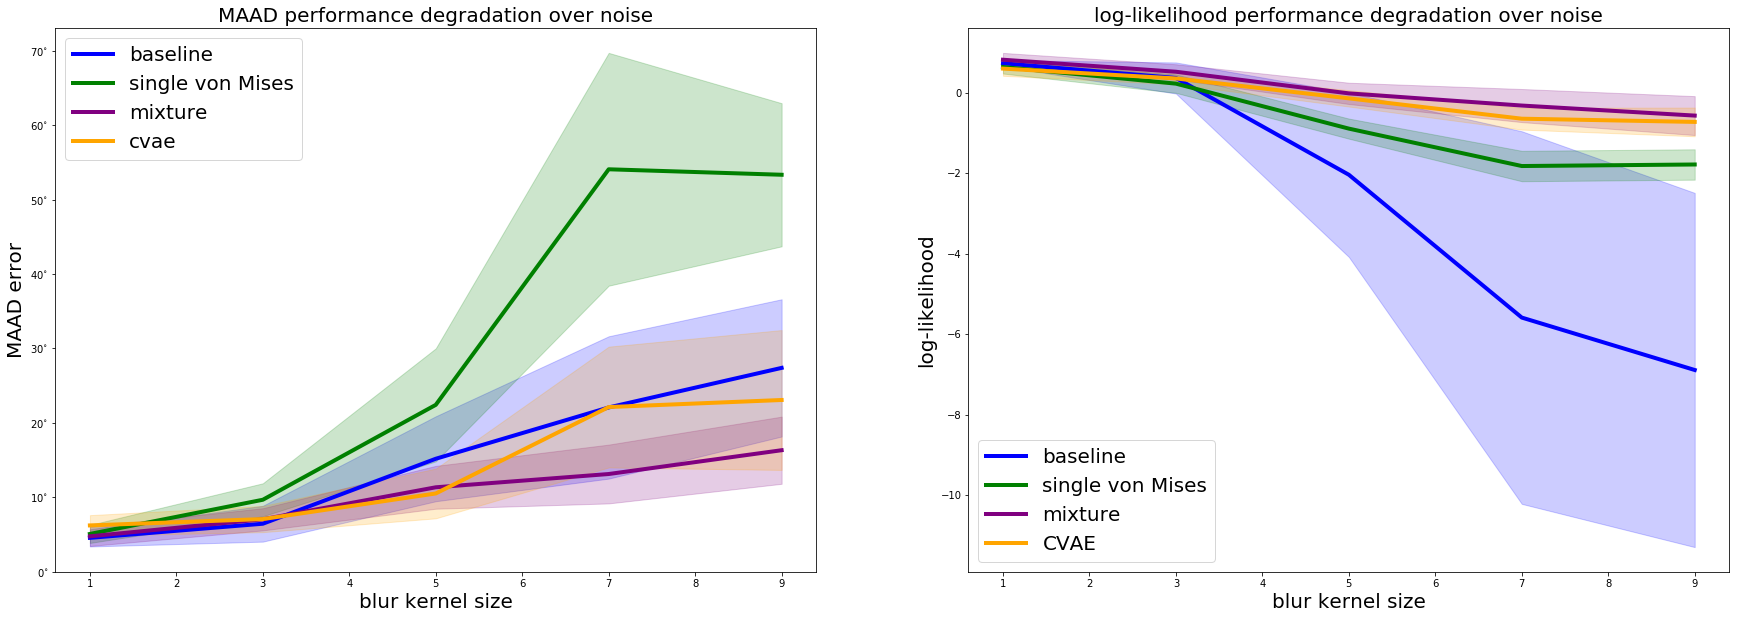

In [75]:
fig, axis = plt.subplots(1, 2, figsize=[30, 10])

maad_ax = axis[0]
likelihood_ax = axis[1]

def draw_performance_curve(axis, xvals, yvals, yvals_sem, label, color): 
    axis.plot(xvals, yvals, color=color, label=label, linewidth=4)
    axis.fill_between(xvals, 
                         yvals-yvals_sem,
                         yvals+yvals_sem,
                         color=color, alpha=0.2)
    return

draw_performance_curve(maad_ax, blur_ksizes, np.asarray(cosine_curves['maad']), 
                       np.asarray(cosine_curves['maad_sem']), 'baseline', 'blue')
draw_performance_curve(maad_ax, blur_ksizes, np.asarray(likelihood_curves['maad']), 
                       np.asarray(likelihood_curves['maad_sem']), 'single von Mises', 'green')
draw_performance_curve(maad_ax, blur_ksizes, np.asarray(mixture_curves['maad']), 
                       np.asarray(mixture_curves['maad_sem']), 'mixture', 'purple')
draw_performance_curve(maad_ax, blur_ksizes, np.asarray(cvae_curves['maad']), 
                       np.asarray(cvae_curves['maad_sem']), 'cvae', 'orange')
#maad_ax.plot(blur_ksizes, likelihood_curves['maad'], label='single von Mises')
#maad_ax.plot(blur_ksizes, mixture_curves['maad'], label='finite mixture')
#maad_ax.plot(blur_ksizes, cvae_curves['maad'], label='CVAE')
maad_ax.legend(loc=2,fontsize=20)
maad_ax.set_yticks(np.arange(0, 80, 10))
maad_ax.set_yticklabels([str(tick)+"$^{\circ}$"  for tick in np.arange(0, 80, 10)])
maad_ax.set_xlabel("blur kernel size", fontsize=20)
maad_ax.set_ylabel("MAAD error", fontsize=20)
maad_ax.set_title("MAAD performance degradation over noise", fontsize=20)


draw_performance_curve(likelihood_ax, blur_ksizes, np.asarray(cosine_curves['log_likelihood']), 
                       np.asarray(cosine_curves['log_likelihood_sem']), 'baseline', 'blue')
draw_performance_curve(likelihood_ax, blur_ksizes, np.asarray(likelihood_curves['log_likelihood']), 
                       np.asarray(likelihood_curves['log_likelihood_sem']), 'single von Mises', 'green')
draw_performance_curve(likelihood_ax, blur_ksizes, np.asarray(mixture_curves['log_likelihood']), 
                       np.asarray(mixture_curves['log_likelihood_sem']), 'mixture', 'purple')
draw_performance_curve(likelihood_ax, blur_ksizes, np.asarray(cvae_curves['log_likelihood']), 
                       np.asarray(cvae_curves['log_likelihood_sem']), 'CVAE', 'orange')

# likelihood_ax.plot(blur_ksizes, cosine_curves['log_likelihood'], label='baseline')
# likelihood_ax.plot(blur_ksizes, likelihood_curves['log_likelihood'], label='single von Mises')
# likelihood_ax.plot(blur_ksizes, mixture_curves['log_likelihood'], label='finite mixture')
# likelihood_ax.plot(blur_ksizes, cvae_curves['log_likelihood'], label='CVAE')
likelihood_ax.legend(loc=3, fontsize=20)
likelihood_ax.set_xlabel("blur kernel size", fontsize=20)
likelihood_ax.set_ylabel("log-likelihood", fontsize=20)
likelihood_ax.set_title("log-likelihood performance degradation over noise", fontsize=20)

fig.show()

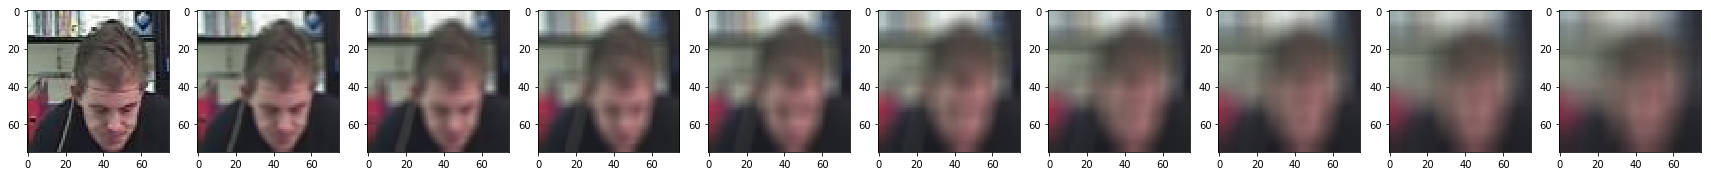

In [130]:
fid =  12 #np.random.randint(0, len(xte))

blur_ksizes = np.arange(1, 21, 2.0, dtype='int8')
blurred_frames = get_blurred_images(xte[fid], blur_ksizes)
blurred_gt_deg = np.squeeze(np.tile(yte_deg[fid], [len(blurred_frames),1]))

show_images(blurred_frames[0:10])

In [129]:
blur_ksizes[4]

9

In [131]:
n_samples = 50

xvals =  np.arange(0, 2*np.pi, 0.01)

n_frames =  len(frames)

results = eval_all_models(blurred_frames, blurred_gt_deg, 'blurred_image', eval_cvae=True, n_samples=n_samples)

pdfs_dict = {}

pdfs_dict['cosine'] = vggbit_cosine_model.pdf(blurred_frames, xvals)

pdfs_dict['likelihood']  = vggbit_likelihood_model.pdf(blurred_frames, xvals)

_, pdfs_dict['mixture'], _ = vmmix_model.pdf(blurred_frames, xvals)

_, pdfs_dict['cvae'] = cvae_model.pdf(blurred_frames, xvals, n_samples=n_samples)

*****EVALUATING ON blurred_image*****
evaluating VGGBit (cosine loss)..
MAAD error (blurred_image) : 34.390114 pm 5.334073SEM
log-likelihood (blurred_image) : -7.391003 pm 1.808161SEM
evaluating VGGBit (likelihood loss)..
MAAD error (blurred_image) : 72.231773 pm 13.460503SEM
log-likelihood (blurred_image) : -1.496819 pm 0.290174SEM
evaluating VM-Mixture..
MAAD error (blurred_image) : 32.451979 pm 4.406641SEM
log-likelihood (blurred_image) : -1.275895 pm 0.308147SEM
evaluating CVAE..
MAAD error (blurred_image) : 27.736066 pm 4.629714SEM
ELBO (blurred_image) : -0.843734 pm 0.284340SEM
Approx Log-Likelihood, importance sampling (blurred_image) : -0.817886 pm 0.283674SEM
KL-div (blurred_image) : 0.041130 pm0.009185SEM


In [114]:
def demo_predictions(x, ytrue_deg, results_dict, pdf_dict, save_path, dataset_name, fig_dpi=100):
    
    n_frames = len(x)
    
    ytrue_rad = np.deg2rad(ytrue_deg)
    
    figures = []
    for fid in range(0, n_frames):
        
        fig = plt.figure(figsize=(20, 7))
        
        for mid, method in enumerate(['cosine', 'likelihood', 'mixture', 'cvae']):

            if dataset_name=="TownCentre":
                img = bgr_to_rgb(x[fid])
            else: 
                img = x[fid]

            if method=='cvae':
                log_likelihood = results_dict[method]['importance_log_likelihood'][fid] 
                show_legend=True
            else:
                log_likelihood = results_dict[method]['log_likelihood'][fid]  
                show_legend=True

            maad = results[method]['maad'][fid]

            if method=='cosine':
                method_title = 'Baseline'
                title = "$\mathbf{Baseline}$ \n\n\n $\Delta_{AAD}$=%.2f°" % (maad)
                #title = "$\mathbf{Baseline}$ \n\n $\log{\mathcal{L}}$=%.2f\n $\Delta_{AAD}$=%.2f°" % (log_likelihood, maad)
                pdf = pdf_dict[method][fid]
                pdf_color = 'blue'
                pred_color = 'darkblue'
            elif method=='likelihood':
                method_title = 'Single von Mises'
                title = "$\mathbf{Single}$ $\mathbf{von}$ $\mathbf{Mises}$\n\n $\log{\mathcal{L}}$=%.2f\n $\Delta_{AAD}$=%.2f°" % (log_likelihood, maad)
                pdf = pdf_dict['likelihood'][fid]
                pdf_color = 'green'
                pred_color = 'darkgreen'
            elif method=='mixture':
                method_title = 'Finite mixture'
                title = "$\mathbf{Finite}$ $\mathbf{mixture}$ \n\n $\log{\mathcal{L}}$=%.2f\n $\Delta_{AAD}$=%.2f°" % (log_likelihood, maad)
                pdf = pdf_dict['mixture'][fid]
                pdf_color = 'purple'
                pred_color = 'purple'
            elif method=='cvae':
                method_title = 'CVAE'
                title = "$\mathbf{CVAE}$ \n\n $\log{\mathcal{L}}$=%.2f\n $\Delta_{AAD}$=%.2f°" % (log_likelihood, maad)
                pdf = pdf_dict['cvae'][fid]
                pdf_color = 'orange'
                pred_color = 'orange'

                #title = "%s \n \n $\log{\mathcal{L}}$=%.2f\n $\Delta_{AAD}$=%.2f°" % (method_title, log_likelihood, maad)
                #title = "$ \log{\mathcal{L}}$=%.2f\n $\Delta_{AAD}$=%.2f°" % (log_likelihood, maad)
            ypred_rad = np.deg2rad(results_dict[method]['point_preds'][fid])

                #title='Frame %d (%s)'%(global_frame_id, method)
            
            axs_img = fig.add_subplot(1, 4, mid+1, frameon=False)
            axs_pdf = fig.add_subplot(1, 4, mid+1, projection='polar')
            
            plot_pdf_circle(axs_pdf, axs_img, img, xvals, 
                                pdf=pdf, 
                                ypred_rad=ypred_rad,
                                ytrue_rad=ytrue_rad[fid],
                                title=title,
                                theta_zero_location=theta_zero_location,
                                pdf_scaler=7.0,
                                show_ticks=False,
                                pdf_color=pdf_color,
                                pred_color=pred_color,
                                show_legend=False)
         
        #fig.suptitle("Gaussian kernel size: %d" % (blur_ksizes[fid]), fontsize=30)
        #%fig.suptitle("%s, test frame %d" % (dataset_name, global_frame_id), fontsize=30)
        
        os.makedirs(save_path, exist_ok=True)
        
        fig.savefig(os.path.join(save_path, "blur_%d.png" % fid), dpi=fig_dpi)

    return figures

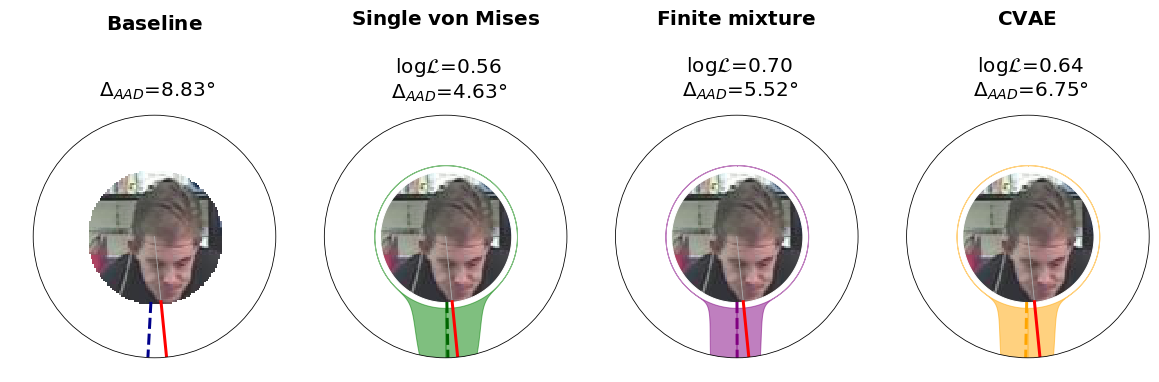

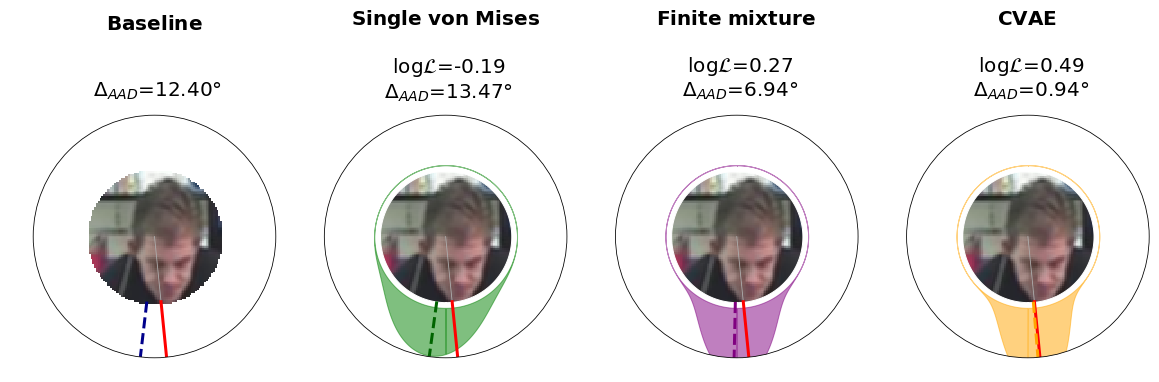

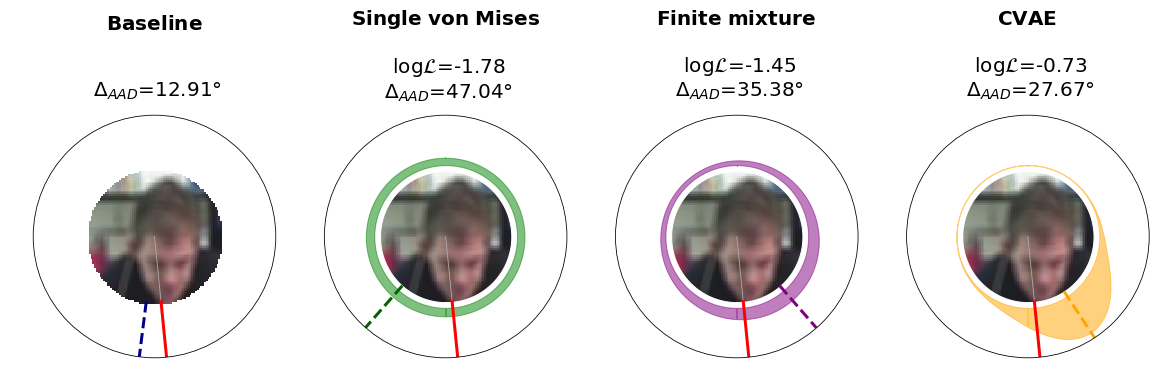

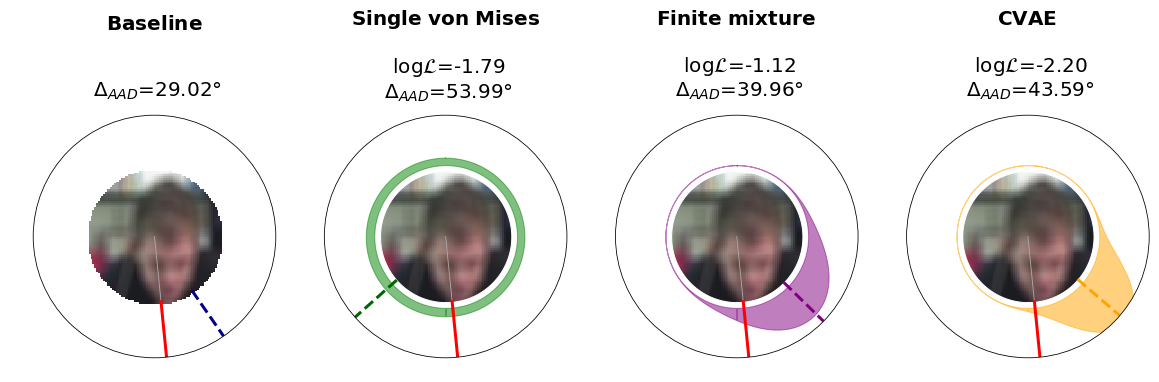

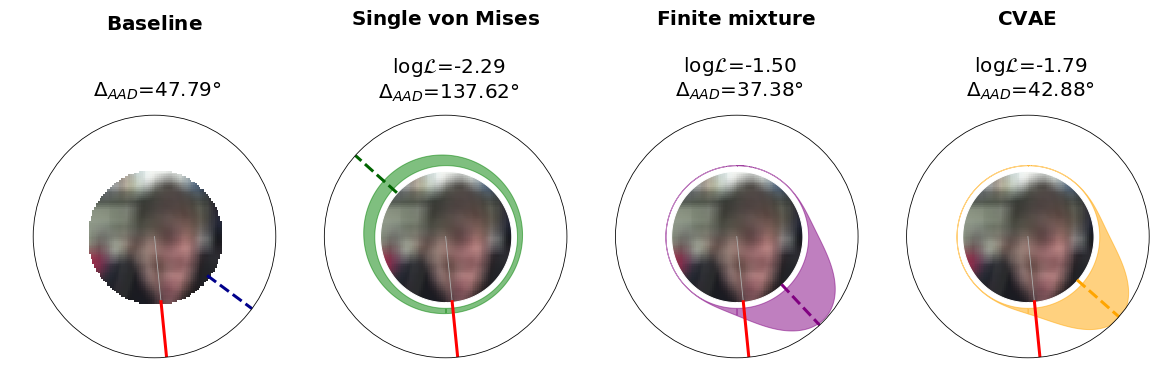

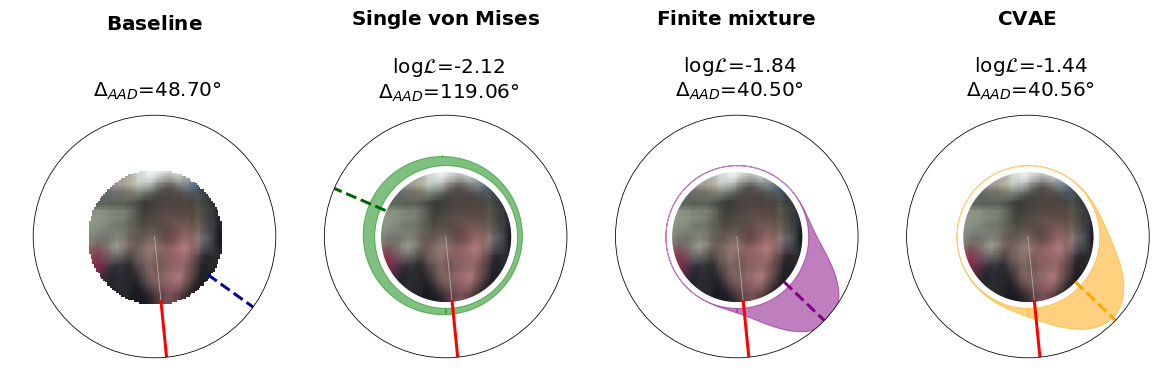

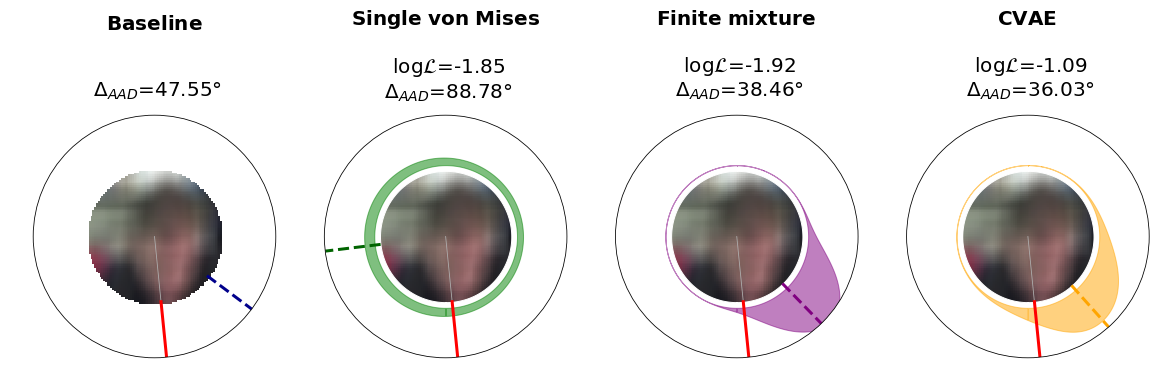

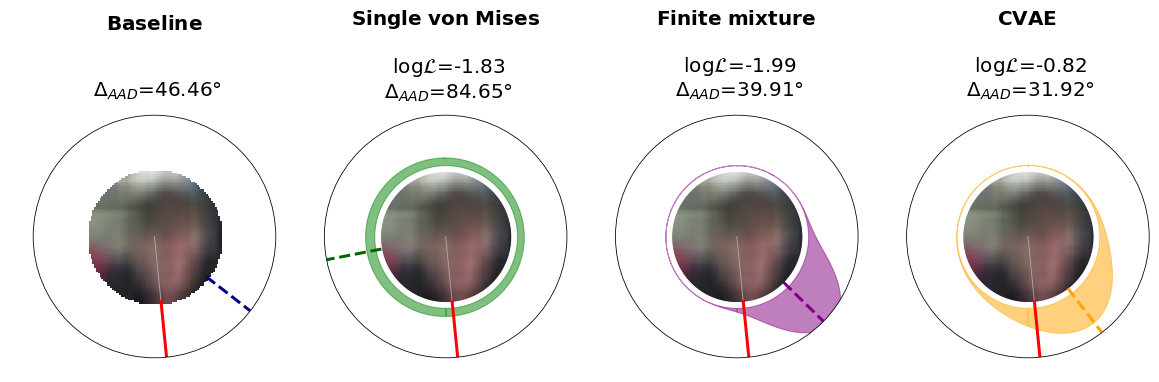

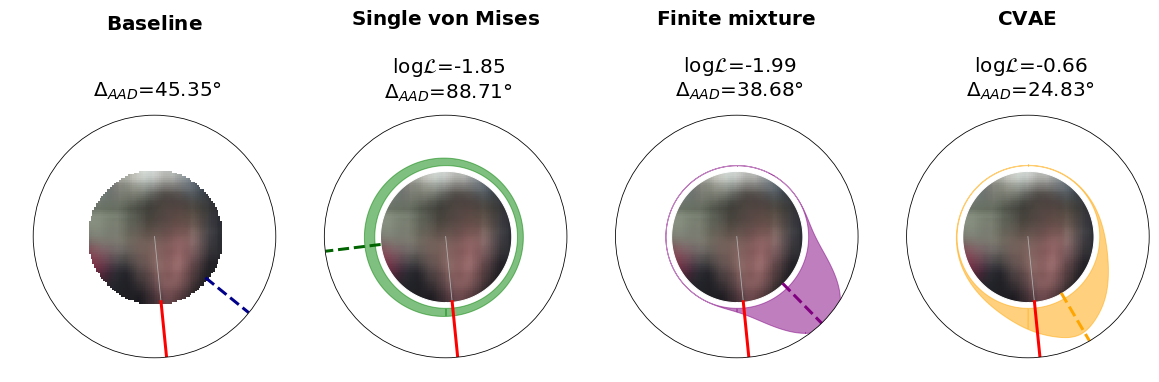

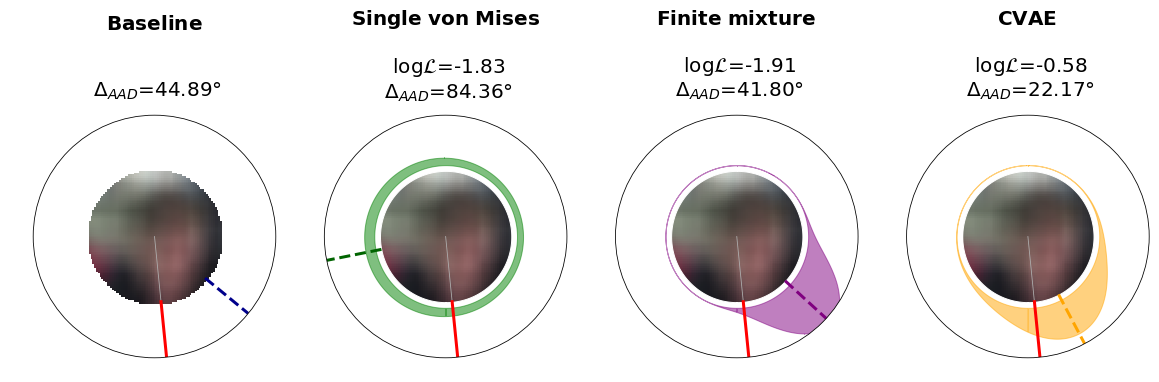

In [132]:
save_path = 'images/IDIAP_blurred/%d' % fid
figs = demo_predictions(blurred_frames, blurred_gt_deg, results, pdfs_dict, save_path, "blurred", fig_dpi=300)

In [663]:
plt.show(figs[0])

In [664]:
figs[0].savefig("/Users/sergey/Downloads/test.png")

In [ ]:
axs_img = fig.add_subplot(1, 4, mid+1, frameon=False)
axs_pdf = fig.add_subplot(1, 4, mid+1, projection='polar')

fig = plot_pdf_circle(axs_pdf, axs_img, img, xvals, 
                pdf=pdf, 
                ypred_rad=ypred_rad,
                ytrue_rad=ytrue_rad,
                title=title,
                theta_zero_location=theta_zero_location,
                pdf_scaler=7.0,
                show_ticks=False,
                pdf_color=pdf_color,
                pred_color=pred_color,
                show_legend=False)

In [754]:
def plot_pdf(axis, xvals, pdf, ypred_rad=None, gt_val_rad=None, title='', show_legend=True):
    
    axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
    axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"], fontsize=25) 
    axis.set_xlim([-0.001, 2*np.pi+0.001])
    #axis.set_xlim([gt_val_rad-0.5*np.pi, gt_val_rad+0.5*np.pi])
    axis.set_ylim([0, 10.0])
#     if gt_val_rad is not None:
#         axis.axvline(gt_val_rad, color='red', linewidth=3, label='$\phi_{true}$ (ground truth)')
    if ypred_rad is not None:
        axis.axvline(ypred_rad, linewidth=3, ls='dashed', color='green', label='$\mu_{pred}$')
        #axis.axvline(ypred_rad, color='blue', label='$\mu_{\\theta}(x)$')
    axis.plot(xvals, pdf, linewidth=2, label='$p_{\\theta}(\phi | \mathbf{x})$')
    #axis.fill_between(xvals, np.zeros(len(xvals)), pdf, color='green', label='$p_{\\theta}(\phi | x)$', alpha=0.5)
    if show_legend:
        axis.legend(fontsize=15)
    #axis.axis("off")
    axis.axes.get_yaxis().set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['left'].set_visible(False)
    #axis.set_title(title, fontsize=15)
    return

def plot_image_results(im, fid, xvals, pdfs_dict, likelihoods_dict, maad_dict, ppreds_dict, ytr_rad):
    
    n_pdfs = len(pdfs_dict)
    
    fig, axs = plt.subplots(1, n_pdfs+1, figsize=(30, 5))
    
    axs[0].set_title("input image")
    axs[0].imshow(im)
    
    i=1
    
    for pdf_name, pdf in pdfs_dict.items():
        ypred_rad = np.deg2rad(ppreds_dict[pdf_name])
        if pdf_name == "CVAE":
            title = "%s (logL$\\approx$%.2f, AAD=%.2f°)" % (pdf_name, likelihoods_dict[pdf_name], maad_dict[pdf_name])
        else:
            title = "%s (logL=%.2f, AAD=%.2f°)" % (pdf_name, likelihoods_dict[pdf_name], maad_dict[pdf_name])
        #title = "%s " % pdf_name
        plot_pdf(axs[i], xvals, pdf, ypred_rad, ytr_rad, title, show_legend=False)
        i+=1
    
    # plot_pdf(axs[1], xvals, acc_pdf, ytr_rad)
    #for sid in range(0, n_components):
        #plot_pdf(axs[2], xvals, samples_pdf[sid], ytr_rad)
    
    fig.suptitle("Frame ID : %d" % fid)
    fig.savefig('images/%d.png'%fid,dpi=100)
    
    return

In [14]:
from utils.angles import bit2deg

yte_rad = np.deg2rad(bit2deg(yte_bit))

#for fix, fid in enumerate(frames[np.random.randint(0, len(frames), 3)]):
#for fix, fid in enumerate(frames):
for fix, fid in enumerate([10729]):
    pdfs_dict = {}
    likelihoods_dict = {}
    point_preds_dict = {}
    maad_dict = {}
    pdfs_dict['baseline'] = vggcosine_acc_pdf[fix]
    likelihoods_dict['baseline'] = results['cosine']['log_likelihood'][fix]
    maad_dict['baseline'] = results['cosine']['maad'][fix]
    point_preds_dict['baseline'] = results['cosine']['point_preds'][fix]
    pdfs_dict['single von Mises'] = vgglikelihood_acc_pdf[fix]
    likelihoods_dict['single von Mises'] = results['likelihood']['log_likelihood'][fix]
    maad_dict['single von Mises'] = results['likelihood']['maad'][fix]
    point_preds_dict['single von Mises'] = results['likelihood']['point_preds'][fix]
    pdfs_dict['VM-Mixture'] = vmmix_acc_pdf[fix]
    likelihoods_dict['VM-Mixture'] = results['mixture']['log_likelihood'][fix]
    maad_dict['VM-Mixture'] = results['mixture']['maad'][fix]
    point_preds_dict['VM-Mixture'] = results['mixture']['point_preds'][fix]
    pdfs_dict['CVAE'] = cvae_acc_pdfs[fix]
    likelihoods_dict['CVAE'] = results['cvae']['importance_log_likelihood'][fix]
    maad_dict['CVAE'] = results['cvae']['maad'][fix]
    point_preds_dict['CVAE'] = results['cvae']['point_preds'][fix]
    #plot_image_results(xte[fid], xvals, cvae_acc_pdfs[fid], cvae_samples_pdfs[fid], yte_rad[fid])
    plot_image_results(xte[fid], fid, xvals,  pdfs_dict, likelihoods_dict, maad_dict, point_preds_dict, yte_rad[fid])

plt.savefig('/Users/sergey/Downloads/single_plain_pdf.png', dpi=300)

NameError: name 'plot_image_results' is not defined

In [751]:
def plot_pdf(axis, xvals, pdf, ypred_rad=None, gt_val_rad=None, title='', show_legend=True):
    
    axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
    axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"], fontsize=16) 
    axis.set_xlim([-0.001, 2*np.pi+0.001])
    #axis.set_xlim([gt_val_rad-0.5*np.pi, gt_val_rad+0.5*np.pi])
    axis.set_ylim([0, 10.0])
    if gt_val_rad is not None:
        axis.axvline(gt_val_rad, color='red', linewidth=3, label='$\phi_{true}$ (ground truth)')
    if ypred_rad is not None:
        axis.axvline(ypred_rad, linewidth=3, ls='dashed', color='green', label='prediction (MEU)')
        #axis.axvline(ypred_rad, color='blue', label='$\mu_{\\theta}(x)$')
    axis.plot(xvals, pdf, linewidth=2)
    #axis.plot(xvals, pdf, linewidth=3, color='green', label='$p_{\\theta}(\phi | x)$')
    if show_legend:
        axis.legend(fontsize=15)
    axis.set_title(title, fontsize=15)
    return

#### Important examples

In [652]:
certain_frame_id = 867
uncertain_frame_id = 4598

vgglikelihood_acc_pdf = vggbit_likelihood_model.pdf(xte[[certain_frame_id, uncertain_frame_id]], xvals)

frames =  [certain_frame_id, uncertain_frame_id] #np.arange(starting_frame, starting_frame+n_frames)

n_samples = 50

xvals =  np.arange(0, 2*np.pi, 0.01)

results = eval_all_models(xte[frames], yte_deg[frames], 'mini_test', eval_cvae=True, n_samples=n_samples)

pdfs_dict = {}

vggcosine_acc_pdf = vggbit_cosine_model.pdf(xte[frames], xvals)

vgglikelihood_acc_pdf = vggbit_likelihood_model.pdf(xte[frames], xvals)

vmmix_pdfs, vmmix_acc_pdf, vmmix_com_probs = vmmix_model.pdf(xte[frames], xvals)

cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(xte[frames], xvals, n_samples=n_samples)

*****EVALUATING ON mini_test*****
evaluating VGGBit (cosine loss)..
MAAD error (mini_test) : 18.963629 pm 14.434302SEM
log-likelihood (mini_test) : -1.878154 pm 2.592150SEM
evaluating VGGBit (likelihood loss)..
MAAD error (mini_test) : 20.673559 pm 16.341376SEM
log-likelihood (mini_test) : -0.153787 pm 1.250253SEM
evaluating VM-Mixture..
MAAD error (mini_test) : 28.147043 pm 28.129025SEM
log-likelihood (mini_test) : 1.394757 pm 1.221963SEM
evaluating CVAE..
MAAD error (mini_test) : 18.470380 pm 16.847553SEM
ELBO (mini_test) : 0.180886 pm 1.401052SEM
Approx Log-Likelihood, importance sampling (mini_test) : 0.435979 pm 1.202503SEM
KL-div (mini_test) : 0.423866 pm0.412172SEM


ValueError: not enough values to unpack (expected 3, got 2)

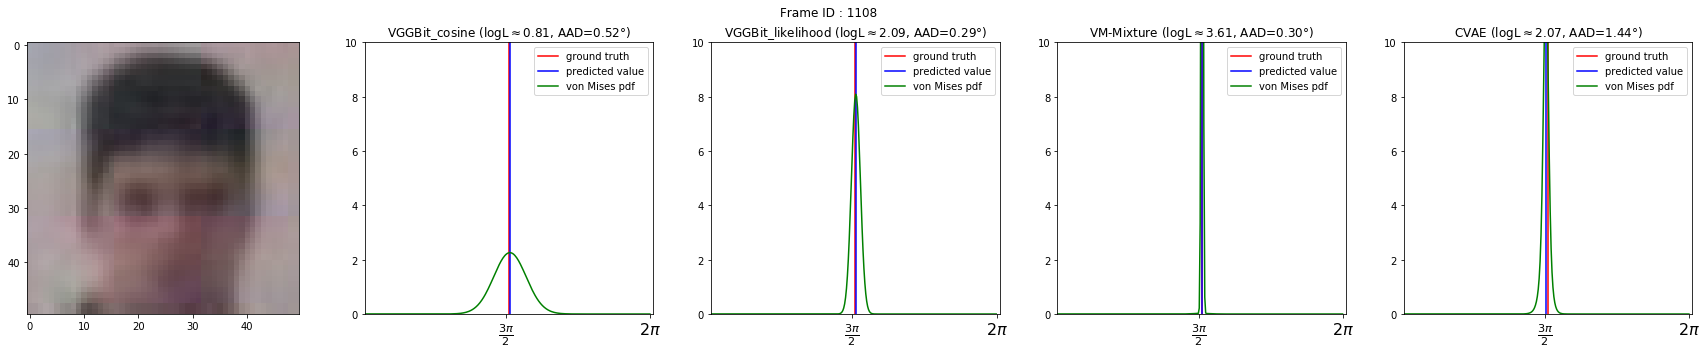

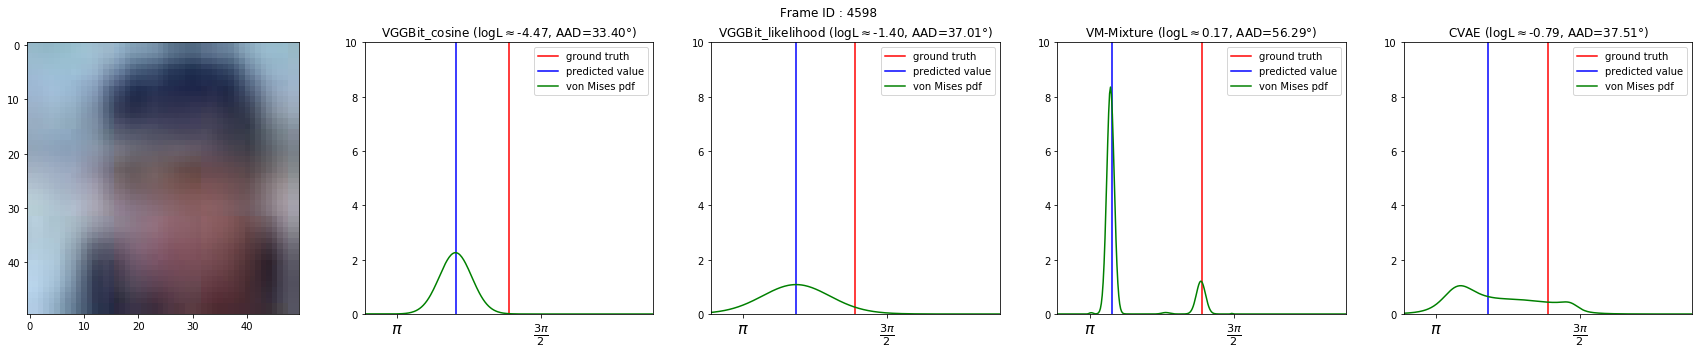

In [222]:
from utils.angles import bit2deg

yte_rad = np.deg2rad(bit2deg(yte_bit))

for fix, fid in enumerate(frames[0:5]):
    
    pdfs_dict = {}
    likelihoods_dict = {}
    point_preds_dict = {}
    maad_dict = {}
    pdfs_dict['VGGBit_cosine'] = vggcosine_acc_pdf[fix]
    likelihoods_dict['VGGBit_cosine'] = results['cosine']['log_likelihood'][fix]
    maad_dict['VGGBit_cosine'] = results['cosine']['maad'][fix]
    point_preds_dict['VGGBit_cosine'] = results['cosine']['point_preds'][fix]
    pdfs_dict['VGGBit_likelihood'] = vgglikelihood_acc_pdf[fix]
    likelihoods_dict['VGGBit_likelihood'] = results['likelihood']['log_likelihood'][fix]
    maad_dict['VGGBit_likelihood'] = results['likelihood']['maad'][fix]
    point_preds_dict['VGGBit_likelihood'] = results['likelihood']['point_preds'][fix]
    pdfs_dict['VM-Mixture'] = vmmix_acc_pdf[fix]
    likelihoods_dict['VM-Mixture'] = results['mixture']['log_likelihood'][fix]
    maad_dict['VM-Mixture'] = results['mixture']['maad'][fix]
    point_preds_dict['VM-Mixture'] = results['mixture']['point_preds'][fix]
    pdfs_dict['CVAE'] = cvae_acc_pdfs[fix]
    likelihoods_dict['CVAE'] = results['cvae']['importance_log_likelihood'][fix]
    maad_dict['CVAE'] = results['cvae']['maad'][fix]
    point_preds_dict['CVAE'] = results['cvae']['point_preds'][fix]
    #plot_image_results(xte[fid], xvals, cvae_acc_pdfs[fid], cvae_samples_pdfs[fid], yte_rad[fid])
    plot_image_results(xte[fid], fid, xvals,  pdfs_dict, likelihoods_dict, maad_dict, point_preds_dict, yte_rad[fid])

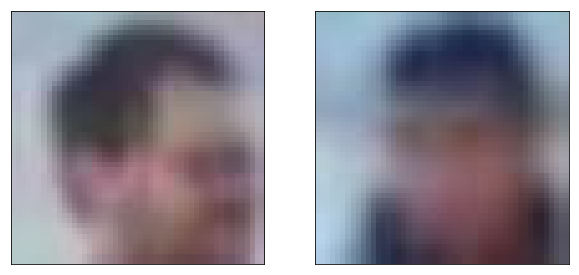

In [277]:
def plot_certain_uncertain(certain_frame, unceratin_frame):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(certain_frame)
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    axs[1].imshow(unceratin_frame)
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    fig.savefig('certain_uncertain.png', dpi=100)
    
    return

plot_certain_uncertain(xte[certain_frame_id], xte[uncertain_frame_id])

In [608]:
def plot_pdf_paper(axis, xvals, pdf, ypred_rad=None, gt_val_rad=None, title='', show_legend=True):
    
    axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
    axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"], fontsize=25) 
    axis.set_yticklabels(np.arange(0, 10), fontsize=20)
    #axis.set_xlim([-0.001, 2*np.pi+0.001])
    axis.set_xlim([gt_val_rad-0.5*np.pi, gt_val_rad+0.5*np.pi])
    axis.set_ylim([0, 10.0])
    if gt_val_rad is not None:
        axis.axvline(gt_val_rad, linewidth=3, color='red', label='$\phi_{true}$')
    axis.plot(xvals, pdf, linewidth=3, color='green', label='$p_{\\theta}(\phi | x)$')
    if ypred_rad is not None:
        axis.axvline(ypred_rad, linewidth=3, ls='dashed', color='green', label='$\mu_{\\theta}(x)$')
    if show_legend:
        axis.legend(fontsize=24)
    axis.set_title(title)
    return

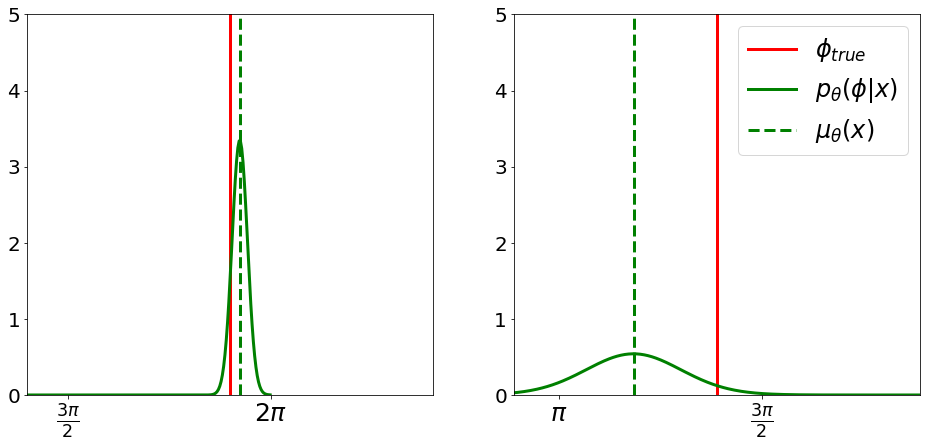

In [297]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

ypreds = np.deg2rad(results['likelihood']['point_preds'])

plot_pdf_paper(axs[0], xvals, vgglikelihood_acc_pdf[0], gt_val_rad=yte_rad[certain_frame_id], ypred_rad=ypreds[0], show_legend=False)
plot_pdf_paper(axs[1], xvals, vgglikelihood_acc_pdf[1], gt_val_rad=yte_rad[uncertain_frame_id], ypred_rad=ypreds[1], show_legend=True)

#plot_pdf(axs[0], xvals, vgglikelihood_acc_pdf[0], gt_val_rad=yte_rad[certain_frame_id], ypred_rad=None, show_legend=False)
#plot_pdf(axs[1], xvals, vgglikelihood_acc_pdf[1], gt_val_rad=yte_rad[uncertain_frame_id], ypred_rad=None, show_legend=True)


fig.savefig('adjusted_densities.png', dpi=300)

In [665]:
np.argsort(component_probs[1, :, :][:,0])

array([10, 43, 35, 13, 49, 23, 40, 24, 17, 44, 21, 15, 11,  1, 20, 27,  2,
       46, 18, 37, 41, 22, 14, 16, 28, 12,  8, 30, 38, 36, 32, 31, 19,  0,
        9,  5,  7, 42,  4, 34, 29, 45, 33, 47, 25,  3, 48,  6, 39, 26])

#### CVAE demo

In [619]:
n_samples = 50
n_frames = 2
demo_frames = np.random.randint(0, len(xte), n_frames)
x_demo = xte[demo_frames]

cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(x_demo, xvals, n_samples=n_samples)

KeyboardInterrupt: 

/Users/sergey/BiternionNet/py_env/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


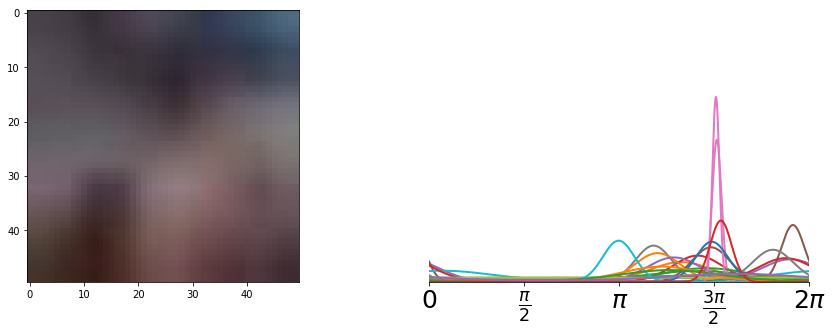

In [756]:
for fid in [2399]:
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for sid in range(25, 50):
        axs[0].imshow(xte[fid])
        plot_pdf(axs[1], xvals, cvae_samples_pdfs[1, sid,:], show_legend=False)
    fig.show()

plt.savefig("/Users/sergey/Downloads/cvae.png", dpi = 300)

In [744]:
cvae_samples_pdfs.shape

(11, 50, 629)

In [650]:
vmmix_pdfs[1, sid,:].shape

(629,)

In [745]:
vmmix_pdfs.shape

(11, 50, 629)